In [2]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict
from tqdm import tqdm
from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")

CLAP_ARCH = "laion/larger_clap_music"


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [3]:
data_path = r"_Data\Music\Music Data New\music_dataset_fixed_Music Data New_tr3141_val390_te398.pt"
clap_model_path = r"CLAP\models\new_fixed\clap_fine_tunned_Fixeed_BatchSize_32_LR_1e-05_Epochs_400_VAL_LOSS_26.47.pt"

In [9]:
class EmbeddedDataset(Dataset):
    def __init__(self, embedded_data):
        self.embedded_data = embedded_data
    def __len__(self):
        return len(self.embedded_data)
    def __getitem__(self, idx):
        x,y= self.embedded_data[idx]
        return x,y

criterion = torch.nn.CrossEntropyLoss()
class MLPHead(torch.nn.Module):
    def __init__(self, input_dim=512, output_dim=6, hidden_dim=256):
        super(MLPHead, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.mlp(x)
    
label_to_index  = {'anger' : 0, 'joy' : 1, 'love' : 2, 'sadness' : 3, 'fear' : 4, 'surprise' : 5}
index_to_label = {v: k for k, v in label_to_index.items()}

In [8]:
def create_embedded_ds_v2(dataset,clap_model,processor):
    embedded_data = list()
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        for batch in tqdm(data_loader,desc="Batches"):
            audio = batch[0]
            labels = list(batch[1])
            unique_labels = list(set(labels))
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            embedded_data.extend([(audio_embed.cpu().detach(), label_to_index[label]) for audio_embed, label in zip(audio_embeds, labels)])
    return EmbeddedDataset(embedded_data)

## Load Data

In [7]:
train_data, val_data, test_data = list(torch.load(data_path, weights_only=False).values())
train_dataset = audio_dataset.AudioDataset(train_data)
val_dataset = audio_dataset.AudioDataset(val_data)
test_dataset = audio_dataset.AudioDataset(test_data)

In [10]:
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
if clap_model_path is not None:
    clap_model.load_state_dict(torch.load(clap_model_path,weights_only=False)['model_state_dict'])
classification_head = MLPHead().to(DEVICE)


## Train MLP Head on CLAP

### Create embedded DS

In [38]:
train_dataset_embedded = create_embedded_ds_v2(train_dataset,clap_model,processor)
val_dataset_embedded = create_embedded_ds_v2(val_dataset,clap_model,processor)
test_dataset_embedded = create_embedded_ds_v2(test_dataset,clap_model,processor)



Batches: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


### Train HEAD

Epoch 1/10000, Loss: 1.7907419204711914, Train Acc : 0.16109519261381725 , Val Acc : 0.16923076923076924
Epoch 2/10000, Loss: 1.7895835638046265, Train Acc : 0.23559375994906082 , Val Acc : 0.24102564102564103
Epoch 3/10000, Loss: 1.7893081903457642, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 4/10000, Loss: 1.7896015644073486, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 5/10000, Loss: 1.789014220237732, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 6/10000, Loss: 1.7888131141662598, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 7/10000, Loss: 1.7889841794967651, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 8/10000, Loss: 1.7874435186386108, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 9/10000, Loss: 1.7877782583236694, Train Acc : 0.24036930913721744 , Val Acc : 0.24102564102564103
Epoch 10/10000, Loss: 1.789236307144165, Train Acc : 0.2

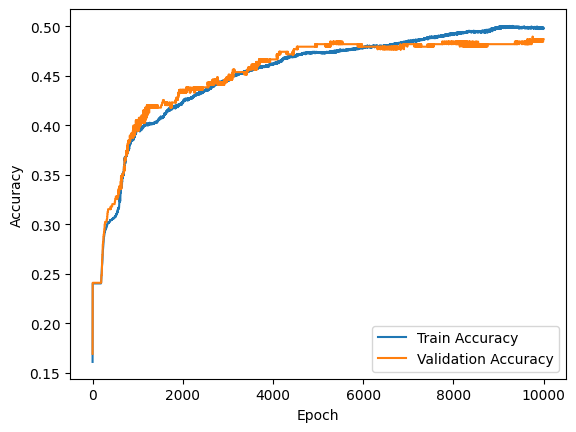

In [43]:
batch_size = 128
epochs = 10000
train_data_loader = DataLoader(train_dataset_embedded, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset_embedded, batch_size=batch_size, shuffle=True)

classification_head = MLPHead().to(DEVICE)
optimizer = torch.optim.Adam(classification_head.parameters(), lr=1e-5)


train_acc = list()
val_acc = list()
best_acc = 0
for e in range(epochs):
    train_correct = 0
    for batch in train_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == labels).item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_acc.append(train_correct/len(train_dataset))
    with torch.no_grad():
        val_correct = 0
        for batch in val_data_loader:
            audio_embeds, labels = batch
            audio_embeds = audio_embeds.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = classification_head(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == labels).item()
        val_acc.append(val_correct/len(val_dataset))
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            best_model ={
                "clap_model": clap_model.state_dict(),
                "mlp_head": classification_head.state_dict(),
                "val_acc": val_acc[-1],
            }
    print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}, Train Acc : {train_acc[-1]} , Val Acc : {val_acc[-1]}")


torch.save(best_model, os.path.join(r"CLAP\models\freeze_clap_train_mlp","classification_head_best.pt"))
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
print("Best Validation Accuracy:", best_acc)

In [44]:
model_path = r"CLAP\models\freeze_clap_train_mlp\classification_head_best.pt"
loaded_model = torch.load(model_path,weights_only=False)
clap_model.load_state_dict(loaded_model['clap_model'])
classification_head.load_state_dict(loaded_model['mlp_head'])

<All keys matched successfully>

In [45]:
test_data_loader = DataLoader(test_dataset_embedded, batch_size=128, shuffle=True)

with torch.no_grad():
    test_correct = 0
    for batch in test_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        test_correct += torch.sum(est_classification == labels).item()
    test_acc = test_correct/len(test_dataset)
print(f"Test Acc : {test_acc}")
print(f"Val Acc : {loaded_model['val_acc']}")

Test Acc : 0.4899497487437186
Val Acc : 0.4897435897435897


### Train CLAP and MLP together

In [ ]:
# Hyperparameters
lrs = [1e-6]
epochs = 50
batch_size = 128

# Data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
best_models = dict()
# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Accuracy lists
acc_list = {"train": [], "val": []}

# Training loop
for lr in lrs:
    # Load the model and processor
    processor = ClapProcessor.from_pretrained(CLAP_ARCH)
    clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
    clap_model.load_state_dict(torch.load(clap_model_path, weights_only=False)['model_state_dict'])

    # Initialize the MLP head
    classification_head = MLPHead().to(DEVICE)
    for param in clap_model.parameters():
        param.requires_grad = False
    # Unfreeze audio projection heads
    for param in clap_model.audio_projection.parameters():
        param.requires_grad = True

    optimizer = torch.optim.AdamW(
        [
            {"params": clap_model.parameters(), "lr": lr},
            {"params": classification_head.parameters(), "lr": 1e-3},
        ]
    )
    print(f"Training with LR: {lr}")
    best_acc = 0
    for e in range(epochs):
        clap_model.train()
        classification_head.train()
        train_correct = 0
        total_loss = 0
        for batch in tqdm(train_data_loader, desc="Train Batches"):
            audio = batch[0]
            train_labels = list(batch[1])
            unique_labels = train_labels[:1]  # Not needed for inference
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            outputs = classification_head(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            train_correct += torch.sum(
                est_classification
                == torch.tensor([label_to_index[label] for label in train_labels]).to(
                    DEVICE
                )
            ).item()
            loss = criterion(
                outputs,
                torch.tensor([label_to_index[label] for label in train_labels]).to(
                    DEVICE
                ),
            )
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc = train_correct / len(train_dataset)
        acc_list["train"].append(train_acc)

        clap_model.eval()
        classification_head.eval()
        val_correct = 0
        with torch.no_grad():
            for batch in tqdm(val_data_loader, desc="Val Batches"):
                audio = batch[0]
                val_labels = list(batch[1])
                unique_labels = val_labels[:1]
                inputs = processor(
                    text=unique_labels,
                    audios=audio.numpy(),
                    return_tensors="pt",
                    sampling_rate=48000,
                    padding=True,
                )
                inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
                outputs = clap_model(**inputs)
                audio_embeds = outputs.audio_embeds
                outputs = classification_head(audio_embeds)
                est_classification = torch.argmax(outputs, dim=1)
                val_correct += torch.sum(
                    est_classification
                    == torch.tensor([label_to_index[label] for label in val_labels]).to(
                        DEVICE
                    )
                ).item()
        val_acc = val_correct / len(val_dataset)
        acc_list["val"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_models[lr] ={
                "clap_model": clap_model.state_dict(),
                "mlp_head": classification_head.state_dict(),
                "val_acc": val_acc,
            }
        print(
            f"Epoch {e+1}/{epochs}, Loss: {total_loss / len(train_data_loader)}, Train Acc: {train_acc}, Val Acc: {val_acc}\n"
        )

    # Print final accuracies
    for key in best_models:
        print(f"Best Validation Accuracy for LR: {key} is {best_models[key]['val_acc']}")
    # print("Final Training Accuracy:", acc_list["train"][-1])
    # print("Final Validation Accuracy:", acc_list["val"][-1])

Training with LR: 1e-06


Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 1/50, Loss: 1.6657702541351318, Train Acc: 0.9000318369945877, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 2/50, Loss: 1.2223918676376342, Train Acc: 0.9856733524355301, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 3/50, Loss: 1.0716734743118286, Train Acc: 0.9888570518943012, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 4/50, Loss: 1.059475450515747, Train Acc: 0.9898121617319325, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]


Epoch 5/50, Loss: 1.0574294853210449, Train Acc: 0.9894937917860553, Val Acc: 0.7512820512820513



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 6/50, Loss: 1.0568529176712036, Train Acc: 0.9885386819484241, Val Acc: 0.7512820512820513



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 7/50, Loss: 1.0548970460891725, Train Acc: 0.9907672715695638, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 8/50, Loss: 1.0544779682159424, Train Acc: 0.9901305316778096, Val Acc: 0.7538461538461538



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 9/50, Loss: 1.0552094984054565, Train Acc: 0.9907672715695638, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 10/50, Loss: 1.0545235538482667, Train Acc: 0.9894937917860553, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 11/50, Loss: 1.053626413345337, Train Acc: 0.9917223814071952, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 12/50, Loss: 1.05373694896698, Train Acc: 0.9898121617319325, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 13/50, Loss: 1.054529414176941, Train Acc: 0.9907672715695638, Val Acc: 0.7512820512820513



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 14/50, Loss: 1.0535404109954833, Train Acc: 0.991085641515441, Val Acc: 0.7538461538461538



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 15/50, Loss: 1.052899250984192, Train Acc: 0.9907672715695638, Val Acc: 0.7564102564102564



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 16/50, Loss: 1.053914222717285, Train Acc: 0.9898121617319325, Val Acc: 0.7538461538461538



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 17/50, Loss: 1.0524463224411011, Train Acc: 0.9920407513530722, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 18/50, Loss: 1.0539927387237549, Train Acc: 0.9898121617319325, Val Acc: 0.7512820512820513



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]


Epoch 19/50, Loss: 1.0522625589370727, Train Acc: 0.9920407513530722, Val Acc: 0.7512820512820513



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 20/50, Loss: 1.0522158861160278, Train Acc: 0.9917223814071952, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 21/50, Loss: 1.0516876745224, Train Acc: 0.9929958611907036, Val Acc: 0.7538461538461538



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 22/50, Loss: 1.0506817817687988, Train Acc: 0.994269340974212, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 23/50, Loss: 1.05208655834198, Train Acc: 0.9920407513530722, Val Acc: 0.7384615384615385



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 24/50, Loss: 1.0542024326324464, Train Acc: 0.9894937917860553, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 25/50, Loss: 1.052820987701416, Train Acc: 0.991085641515441, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 26/50, Loss: 1.053552770614624, Train Acc: 0.991085641515441, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 27/50, Loss: 1.0525987482070922, Train Acc: 0.991085641515441, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 28/50, Loss: 1.0529799413681031, Train Acc: 0.9904489016236867, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 29/50, Loss: 1.0503799533843994, Train Acc: 0.994269340974212, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 30/50, Loss: 1.0516993188858033, Train Acc: 0.9929958611907036, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 31/50, Loss: 1.0517750072479248, Train Acc: 0.9926774912448265, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 32/50, Loss: 1.0532979106903075, Train Acc: 0.9904489016236867, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 33/50, Loss: 1.0520238208770751, Train Acc: 0.9920407513530722, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 34/50, Loss: 1.0508270931243897, Train Acc: 0.9933142311365807, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Epoch 35/50, Loss: 1.0525107049942017, Train Acc: 0.9907672715695638, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 36/50, Loss: 1.0512076663970946, Train Acc: 0.9920407513530722, Val Acc: 0.7384615384615385



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 37/50, Loss: 1.0521705341339112, Train Acc: 0.9923591212989494, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]


Epoch 38/50, Loss: 1.0512993764877319, Train Acc: 0.9923591212989494, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 39/50, Loss: 1.0519452381134033, Train Acc: 0.9920407513530722, Val Acc: 0.7461538461538462



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 40/50, Loss: 1.0509571743011474, Train Acc: 0.9933142311365807, Val Acc: 0.7564102564102564



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 41/50, Loss: 1.0514341735839843, Train Acc: 0.9926774912448265, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 42/50, Loss: 1.0520552921295165, Train Acc: 0.9914040114613181, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 43/50, Loss: 1.05287672996521, Train Acc: 0.9920407513530722, Val Acc: 0.7487179487179487



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


Epoch 44/50, Loss: 1.0509853124618531, Train Acc: 0.9933142311365807, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 45/50, Loss: 1.0505009269714356, Train Acc: 0.993950971028335, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 46/50, Loss: 1.0510488939285278, Train Acc: 0.9923591212989494, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 47/50, Loss: 1.0507187747955322, Train Acc: 0.9933142311365807, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 48/50, Loss: 1.051751275062561, Train Acc: 0.9923591212989494, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 49/50, Loss: 1.0507590055465699, Train Acc: 0.9933142311365807, Val Acc: 0.7435897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.88s/it]

Epoch 50/50, Loss: 1.0498077964782715, Train Acc: 0.9933142311365807, Val Acc: 0.7512820512820513

Best Validation Accuracy for LR: 1e-06 is 0.7564102564102564


In [133]:
path = r"CLAP\models\fine_tuned_clap_mlp_train_together"
for lr,model in best_models.items():
    torch.save(model,os.path.join(path,f"model_dict_lr_{lr}_v2.pt"))
    print(model['val_acc'])


0.7564102564102564


In [34]:
model_path = r"CLAP\models\fine_tuned_clap_mlp_train_together\model_dict_lr_1e-06_v2.pt"
loaded_model = torch.load(model_path,weights_only=False)
clap_model.load_state_dict(loaded_model['clap_model'])
classification_head.load_state_dict(loaded_model['mlp_head'])


<All keys matched successfully>

In [35]:
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
test_correct = 0

confusion_matrix = torch.zeros(6,6)
all_labels = list()
with torch.no_grad():
    for batch in tqdm(test_data_loader,desc="Test Batches"):
        audio = batch[0]
        test_labels = list(batch[1])
        all_labels.extend(test_labels)
        inputs = processor(
            text=test_labels[:1],
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = clap_model(**inputs)
        audio_embeds = outputs.audio_embeds
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        correct_label_index = torch.tensor([label_to_index[label] for label in test_labels])
        is_correct = est_classification.cpu() == correct_label_index
        for est,correct in zip(est_classification,correct_label_index):
            confusion_matrix[correct][est] += 1
        test_correct += torch.sum(is_correct).item()
    test_acc = test_correct / len(test_dataset)
    print(f"Test Acc: {test_acc}\n")

Test Batches: 100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

Test Acc: 0.7537688442211056



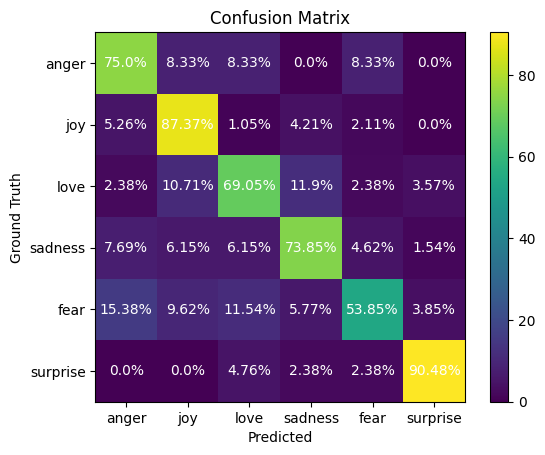

In [37]:
import numpy as np
confusion_matrix = 100*confusion_matrix/confusion_matrix.sum(dim=1).reshape(-1,1)
plt.imshow(confusion_matrix)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.xticks(ticks=np.arange(len(label_to_index)), labels=label_to_index.keys())
plt.yticks(ticks=np.arange(len(label_to_index)), labels=label_to_index.keys())
# Annotate each cell with the numeric value
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, f"{round(confusion_matrix[i, j].item(),2)}%", ha='center', va='center', color='white')



In [34]:
for label,counter in Counter(all_labels).items():
    print(f"Label {label} : {100*correct_per_label[label]/counter : .2f}%")


Label anger :  65.00%
Label surprise :  88.10%
Label fear :  57.69%
Label sadness :  67.69%
Label love :  61.90%
Label joy :  87.37%
